[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/time-series/time-series-stocks-pattern-example.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/time-series/time-series-stocks-pattern-example.ipynb)

# Time Series Similarity Search 
Time series, a sequence of values ordered by time, is one of the fundamental data forms. Consequently, there are plentiful time-series analysis methods and tools, ranging from forecasting to anomaly detection. 

Here we demonstrate how to perform time-series "pattern" matching using a similarity search service. Wherein we want to retrieve all historical time series that match a particular pattern. Such matching capability serves as a core ingredient for time series applications such as clustering, labeling, and recommendation. For example, consider a time series describing web page visitors and a need to retrieve all historical peak surges, drops, or trends. 

We will walk you through a simple approach that utilizes the time series raw data as-is. In other words, it does not require any modeling heavy lifting. Such an approach is very appealing because it does not require any domain-specific technical knowledge nor extra model generation resources. Sounds too good to be true?

Our demo indicates that this simple approach provides satisfying results. We will show you how to index and search a set of stock market daily prices time series. Then we will compare the simple approach with an alternative that utilizes a comprehensive time-series library recently published by Facebook AI. 

What we'll cover:
* Prerequisites
* Simple Time-Series Embeddings
    * Prepare data
    * Index
    * Search
* Facebook's [Kats](https://engineering.fb.com/2021/06/21/open-source/kats/) Time-Series Embeddings
    * Index
    * Search
* Conclusion

## Prerequisites
Install and import relevant python packages

In [ ]:
!pip install kats==0.2.0 matplotlib==3.1.3 scikit-learn==1.0.2 pandas==1.3.5 pinecone-client convertdate kaggle

*If you are using Google Colab, please restart the runtime in order to use newly installed package versions.*

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
from sklearn.preprocessing import MinMaxScaler
from kats.consts import TimeSeriesData
from kats.tsfeatures.tsfeatures import TsFeatures
import itertools
from decimal import Decimal
from IPython.display import clear_output

import warnings
warnings.simplefilter(action='ignore')

## Simple Time-Series Embeddings

### Upload Time Series to Pinecone's Similarity Search Service
In the steps below how to set up Pinecone's similarity search service and upload the time series into the service's *Index* data structure. Pinecone stores and searches [vector embeddings](https://www.pinecone.io/learn/vector-embeddings/). These embeddings or feature vectors are a numerical representation of raw data semantics. 

Recall that we want to create two indexes: 
* An index that contains vectors representing the raw data of historical prices of different stocks. In other words, vector embedding is simply the time-series sequence of numbers. 
* An index that stores feature embeddings calculated using Facebook's [Kats toolkit](https://engineering.fb.com/2021/06/21/open-source/kats/). Kats is a powerful time-series analysis tool that includes a time-series [embedding functionality](https://github.com/facebookresearch/Kats#tsfeatures). 

### Configure Pinecone
Let's start by configuring the Pinecone service. 

#### Pinecone Setup

In [2]:
import pinecone

In [4]:
# Load Pinecone API key
api_key = os.getenv('PINECONE_API_KEY') or 'YOUR_API_KEY'
# Set Pinecone environment. You can find your environment in the Pinecone console (https://app.pinecone.io) under Indexes.
env = os.getenv('PINECONE_ENVIRONMENT') or 'YOUR_ENVIRONMENT'
pinecone.init(api_key=api_key, environment=env)

[Get your API key](https://www.pinecone.io/start/) and try this example yourself!

#### Create a New Service

Let's start with the simple approach and create an index.

In [5]:
# Pick a name for the new index
simple_index_name = 'stocks-trends'

In [6]:
# Check whether the index with the same name already exists
if simple_index_name in pinecone.list_indexes():
    pinecone.delete_index(simple_index_name)

In [7]:
# Create a new index
pinecone.create_index(name=simple_index_name, dimension=128)

In [8]:
# Establish a connection
simple_index = pinecone.Index(index_name=simple_index_name)

### Prepare data
Starting with the simple embedding approach described earlier. Wherein we represent a time series as a vector of the time series sequence of numbers. 

Throughout the demo, we use a [Stock Market Dataset](https://www.kaggle.com/jacksoncrow/stock-market-dataset). This dataset contains historical daily prices for all tickers trading on NASDAQ, up to April 2020. The dataset is defined in Kaggle and requires either a manual download or a Kaggle API to download it.

The data processing (i.e., [ETL part](https://en.wikipedia.org/wiki/Extract,_transform,_load)) here is heavy lifting and includes:
* Downloading the data from [Kaggle](https://www.kaggle.com/jacksoncrow/stock-market-dataset). (Recall, you will need a [Kaggle API key](https://www.kaggle.com/docs/api).) 
* Define the time series raw data. 
* Extract the time series from the relevant files. 
* Transform the raw data into vectors and upload the vectors into Pinecone's service.

#### Download Kaggle Stock Market Dataset

In order to use the Kaggle’s public API, you must first authenticate using an API token. Please replace the username and key values in the following cell with the values from your [Kaggle API token](https://www.kaggle.com/docs/api#getting-started-installation-&-authentication).

In [9]:
%%writefile kaggle.json
{"username":"KAGGLE_USERNAME","key":"KAGGLE_KEY"}

Writing kaggle.json


In [ ]:
#Check Kaggle username and key
! cat ./kaggle.json

In [11]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jacksoncrow/stock-market-dataset
!unzip -q stock-market-dataset.zip -d data

100% 521M/522M [00:04<00:00, 126MB/s]
100% 522M/522M [00:04<00:00, 125MB/s]


#### Set up Time Series Hyperparameters
We set two hyperparameters defining how we extract the time series:
* sliding window, which controls the length of the time series in consecutive day periods.
* step size, which defines a gap in the start dates of two consecutive vectors.

Feel free to set the window or step size to a different value. 

In [12]:
# Define sliding window and step size
SLIDING_WINDOW_SIZE = 64
STEP = 10

#### Define Extract-Transform-Load Functions
Before we do all of the other steps, we will define utility functions to help us extract, transform, and upload the time series data.

Note that we will:
* Work only with the stock prices and disregard the ETF data folder.
* Load data for a set of symbols from the stock folder for the simplicity of the example.
* When creating vectors, we will include daily *Open* and *Close* prices. This way, our vectors will be double the size of a sliding window. Feel free to try different prices when creating vectors.

In [13]:
def windows(data, window_size, step):
    r = np.arange(len(data))
    s = r[::step]
    z = list(zip(s, s + window_size))
    f = '{0[0]}:{0[1]}'.format
    g = lambda t: data.iloc[t[0]:t[1]]
    return pd.concat(map(g, z), keys=map(f, z))

def get_feature_embedding_for_window(df, stock):
    ts_name = f"{stock.strip('.csv')}_{str(df.Date.min())}_{str(df.Date.max())}"
    scaler=MinMaxScaler()
    df[['Open', 'Close']] = scaler.fit_transform(df[['Open', 'Close']])
    prices = df[['Open', 'Close']].values.tolist()
    flat_values = [item for sublist in prices for item in sublist]
    df = df.rename(columns={"Date":"time"}) 
    ts_df = pd.DataFrame({'time':df.time.repeat(2), 
                          'price':flat_values})
    ts_df.drop_duplicates(keep='first', inplace=True)  

    # Use Kats to extract features for the time window
    try:
        if not (len(np.unique(ts_df.price.tolist())) == 1 \
            or len(np.unique(ts_df.price.tolist())) == 0):
            timeseries = TimeSeriesData(ts_df)
            features = TsFeatures().transform(timeseries)
            feature_list = [float(v) if not pd.isnull(v) else float(0) for _, v in features.items()]
            if Decimal('Infinity') in feature_list or Decimal('-Infinity') in feature_list:
                return None
            return (ts_name, feature_list)
    except np.linalg.LinAlgError as e:
        print(f"Can't process {ts_name}:{e}")
    return None

def get_simple_pair_for_window(df, stock):
    ts_name = f"{stock.strip('.csv')}_{str(df.Date.min())}_{str(df.Date.max())}"
    prices = df[['Open', 'Close']].values.tolist()
    flat_values = [item for sublist in prices for item in sublist]
    return (ts_name, flat_values)

def chunks(iterable, batch_size=100):
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

In [14]:
def upload_data_to_index(index, create_pair_func, verbose=False):
    # Define path to the folder
    stocks = sorted(os.listdir('./data/stocks'))
    
    # Iterate over files, create vectors and upload data
    for stock in stocks[::50]:
        print(stock.strip('.csv'))
        data = pd.read_csv(os.path.join('./data/stocks', stock))
        data = data.sort_index(axis=0, ascending=True)
        data["Date"] = pd.to_datetime(data["Date"]).dt.date

        # Interpolate data for missing dates
        data.set_index('Date', inplace=True)
        data = data.reindex(pd.date_range(start=data.index.min(),
                                          end=data.index.max(),
                                          freq='1D'))
        data = data.interpolate(method='linear')
        data = data.reset_index().rename(columns={'index': 'Date'})
        data["Date"] = pd.to_datetime(data["Date"]).dt.date
        
        # Create sliding windows dataset
        wdf = windows(data, SLIDING_WINDOW_SIZE, STEP)
        
        # Prepare sequences for upload 
        items_to_upload = []
        for window, new_df in wdf.groupby(level=0):
            if new_df.shape[0] == SLIDING_WINDOW_SIZE:
                pair = create_pair_func(new_df, stock)
                if pair:
                    items_to_upload.append(pair)

        # Upload data for the symbol
        for batch in chunks(items_to_upload, 500):
            index.upsert(vectors=batch)

### Index
Let's upsert data into the simple index.

In [15]:
upload_data_to_index(simple_index, get_simple_pair_for_window)
clear_output()

In [16]:
# Check the index size
simple_index.describe_index_stats()

{'dimension': 128, 'namespaces': {'': {'vector_count': 61212}}}

### Search
Now that we have uploaded the items into the vector index, it is time to check the similarities between vectors.

In this section, we will:
* Define stocks and their windows for the query.
* Fetch these query items from the index to retrieve their vectors.
* Query the index using these vectors. Pinecone will return top K most similar vectors for each query item.
* Show the results.

Below we define utility functions for data preparation and display.

In [17]:
def prepare_items_for_graph(data):    
    scaler = MinMaxScaler()
    result_list = []
    
    for _, row in data.iterrows():
        id = row['id']
        vec = row['values']
        scaled_vec = scaler.fit_transform(np.array(vec).reshape(-1,1))
        result_list.append((id, (vec, scaled_vec)))
    return result_list

In [18]:
def show_query_results(query_item, data):
    data_prepared = prepare_items_for_graph(data)
    graph_index = pd.Float64Index(np.arange(start=0, stop=SLIDING_WINDOW_SIZE, step=0.5))

    print('\n The most similar items from the vector index:')
    data.reset_index(inplace=True, drop=True)
    display(data)
      
    fig = plt.figure(figsize=(20,7))
    for item in data_prepared:
        _id, vectors = item
        ax1 = plt.subplot(1, 2, 1)
        graph = plt.plot(graph_index, vectors[0], label = _id, marker='o' if _id == query_item else None)
        ax2 = plt.subplot(1, 2, 2)
        graph = plt.plot(graph_index, vectors[1], label = _id, marker='o' if _id == query_item else None)    
    ax1.set_xlabel("Days in time window")
    ax2.set_xlabel("Days in time window")
    ax1.set_ylabel("Stock values")
    ax2.set_ylabel("Normalized Stock Values")
    ax1.title.set_text(f'Similar stock patterns and their market values')
    ax2.title.set_text(f'Similar stock patterns and their normalized market values')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

Note that we will filter the retrieved results to make sure we present a diverse set of stocks. Otherwise, we might get consecutive time windows for the same stock.

In [19]:
def filter_results(query_item, data, historical_only=False):
    already_present = []
    
    # Remove symbol that is already included
    for i, row in data.iterrows():
        check_name = row.id.split('_')[0]
        if check_name not in already_present:
            already_present.append(check_name)
        else:
            data.drop(i,axis=0,inplace=True)
            
    # Include only data prior to query interval
    if historical_only:
        _, start_dt, end_dt = query_item.split('_')
        start_dt = pd.to_datetime(start_dt).date()
        data['final_date'] = data.id.apply(lambda x: x.split('_')[2])
        data['final_date'] =  data.final_date.apply(lambda x: pd.to_datetime(x).date())
        data = data[data.final_date <= start_dt]
        del data['final_date']
       
    return data

#### Numerical Examples
Let's examine a few interesting price patterns and their corresponding best matches.

Here we define the query items, fetch them and prepare vectors for the query.

In [20]:
# Define query examples
items_to_query = ['BORR_2019-10-18_2019-12-20', 'HCCO_2020-01-28_2020-03-31', 'PUMP_2019-11-22_2020-01-24']

# Fetch vectors from the index
fetch_res = simple_index.fetch(ids=items_to_query)

# Create a list of ids and vectors for the fetched items
query_ids = [res.id for res in fetch_res.vectors.values()]
query_vectors = [res.values for res in fetch_res.vectors.values()]

The next step is to perform the query for the query vectors. 

In [21]:
# Query the pinecone index
query_results = []
for xq in query_vectors:
    res = simple_index.query(xq, top_k=100, include_values=True)
    query_results.append(res)

Finally, iterate over the results, get all vectors needed for the graphs and display them.

Note that graphs on the left show the absolute price values for the query items selected, while graphs on the right show each vector on a 0-1 scale. The price normalization ignores the magnitude of stock prices and thus focuses on the time series pattern only. 

It is more likely that similar trends appear in the same time interval. There is a flag **historical_only** that lets you choose whether you want to look only at the time intervals prior to query time interval or any time interval that exists.


Queried: BORR_2019-10-18_2019-12-20

 The most similar items from the vector index:


,id,score,values
0,BORR_2019-10-18_2019-12-20,1.000000,"[6.22, 6.4, 6.45, 6.4666667, 6.68, 6.5333333, ..."
1,OSK_1990-11-25_1991-01-27,0.999467,"[1.23611116, 1.25, 1.25, 1.25, 1.25, 1.2916666..."
2,BH_2009-10-21_2009-12-23,0.999386,"[197.943146, 192.080719, 207.771332, 206.90921..."
3,MLAB_2007-03-30_2007-06-01,0.999307,"[19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19...."
4,SORL_2008-03-19_2008-05-21,0.999293,"[5.1, 4.93, 4.9, 4.93, 4.9425, 4.9525, 4.985, ..."
5,PKBK_2012-12-02_2013-02-03,0.999265,"[3.78662658, 3.77160025, 3.77160025, 3.7716002..."


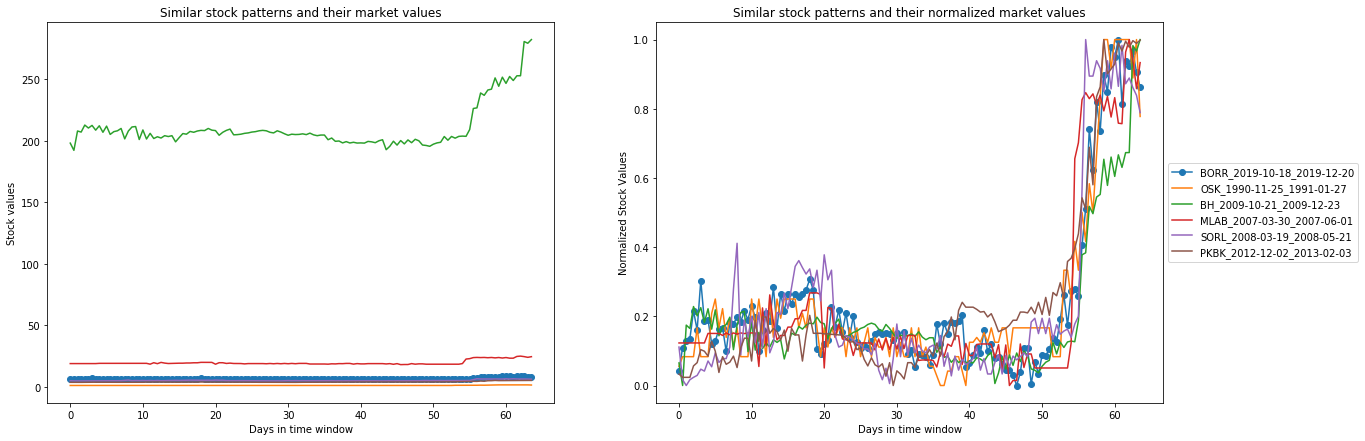

,id,score,values
0,HCCO_2020-01-28_2020-03-31,1.000000,"[9.95, 10.0, 10.05, 10.05, 10.05, 10.05, 10.05..."
1,TEI_2016-09-22_2016-11-24,0.999958,"[10.98, 11.0, 10.99, 10.96, 10.9933329, 10.956..."
2,BSD_2002-01-31_2002-04-04,0.999945,"[14.04, 14.0, 14.04, 14.0, 14.04, 13.9933329, ..."
3,HPI_2016-07-26_2016-09-27,0.999943,"[23.21, 23.23, 23.25, 23.26, 23.2, 23.27, 23.2..."
4,MUE_2007-09-23_2007-11-25,0.999943,"[12.2566671, 12.26, 12.25, 12.26, 12.26, 12.35..."
5,AMCI_2016-10-04_2016-12-06,0.999942,"[0.488, 0.488, 0.488, 0.488, 0.488, 0.488, 0.4..."



Queried: HCCO_2020-01-28_2020-03-31

 The most similar items from the vector index:


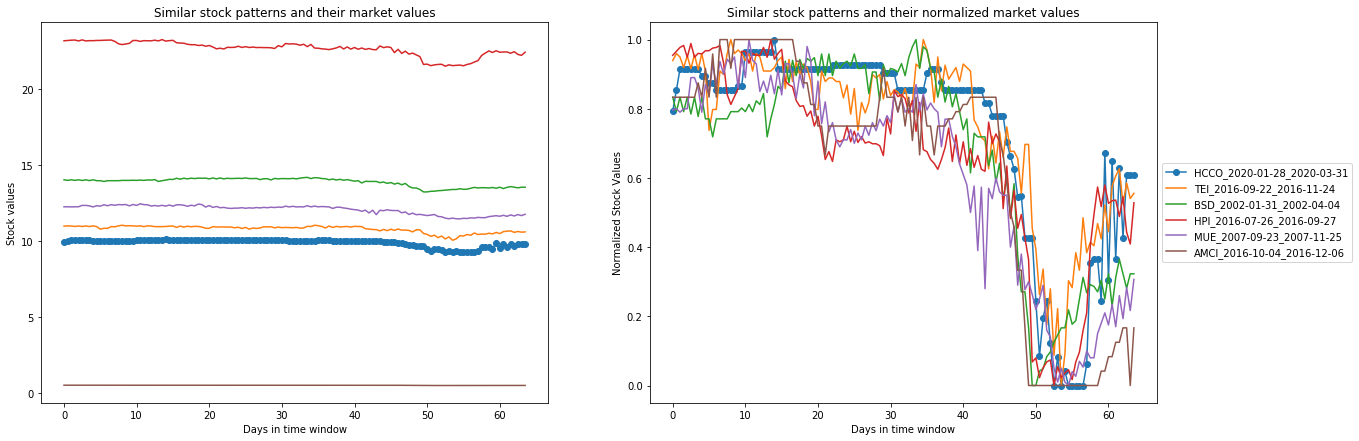


Queried: PUMP_2019-11-22_2020-01-24

 The most similar items from the vector index:


,id,score,values
0,PUMP_2019-11-22_2020-01-24,1.000000,"[8.34, 8.27, 8.31333351, 8.42, 8.28666687, 8.5..."
1,AEL_2003-12-14_2004-02-15,0.999547,"[9.06333351, 9.04, 9.06, 9.01, 9.06, 9.02, 9.0..."
2,THS_2006-10-21_2006-12-23,0.999510,"[24.503334, 24.376667, 24.3266659, 24.4233322,..."
3,RUBY_2008-07-05_2008-09-06,0.999508,"[5.02380943, 5.02380943, 4.97619057, 4.9761905..."
4,SRI_2010-11-11_2011-01-13,0.999495,"[12.82, 12.78, 12.61, 12.71, 12.6799994, 12.67..."
5,BH_2017-11-18_2018-01-20,0.999465,"[343.266663, 341.956665, 342.693329, 340.48333..."


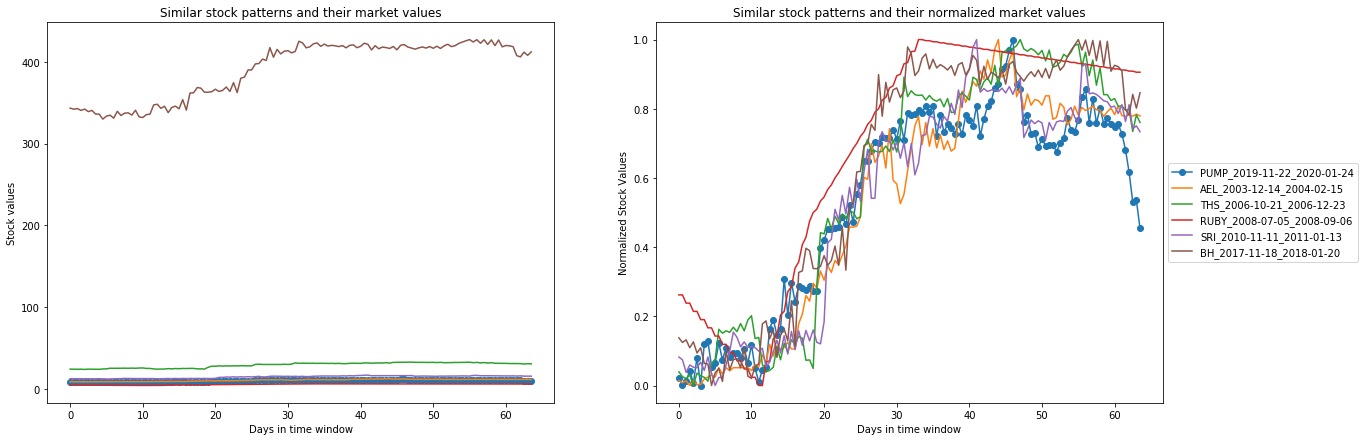

In [22]:
# Iterate and show query results for each query item
for query_item, q_res in zip(query_ids, query_results):
    print(f'\nQueried: {query_item}')
    res_df = pd.DataFrame(
        {
            'id': [res.id for res in q_res.matches], 
            'score': [res.score for res in q_res.matches],
            'values': [res.values for res in q_res.matches]
         }
    )
    res_df = filter_results(query_item, res_df, historical_only=False)
    show_query_results(query_item, res_df.head(6))

Notice that we found patterns that look alike and are related to different stocks and different time windows.

## Facebook's Kats Time-Series Embeddings
It is time to test another approach. This time we create feature embeddings and upload them using the same stocks and windows as in our previous index. Here we utilize Facebook's [Kats toolkit](https://engineering.fb.com/2021/06/21/open-source/kats/). Kats is a powerful time-series analysis tool that includes a time-series [embedding functionality](https://github.com/facebookresearch/Kats#tsfeatures). 

Let's create a new index first.

### Create a New Pinecone Service

In [23]:
# Pick a name for the new index
kats_index_name = 'stocks-trends-with-features'

In [24]:
# Check whether the index with the same name already exists
if kats_index_name in pinecone.list_indexes():
    pinecone.delete_index(kats_index_name)

In [25]:
# Create a new index
pinecone.create_index(name=kats_index_name, dimension=40)

In [26]:
# Establish a connection
kats_index = pinecone.Index(index_name=kats_index_name)

### Index
We will use Kats and its time-series feature extraction module to create feature embeddings for each stock and corresponding time window. These feature embeddings include the following types: seasonality, autocorrelation, modeling parameter, changepoints, moving statistics, and raw statistics of time series array as the ad-hoc features. We used the default set of features for our example and created 40-dimensional feature embeddings.

*Note: Ignore the Kats warning message that appears in the output.*

In [27]:
upload_data_to_index(kats_index, get_feature_embedding_for_window)
clear_output()

In [28]:
kats_index.describe_index_stats()

{'dimension': 40, 'namespaces': {'': {'vector_count': 61105}}}

*Note* that the Kats-based index has fewer vectors compared to the simple embeddings index. It happens because Kats fails to calculate some features for some patterns. E.g., it happens if the time series has a constant value each day in a time window.


### Search

We will use the same query item that we used to query the simple index.

In [29]:
# Fetch vectors from the index
fetch_res = kats_index.fetch(ids=items_to_query)

# Create a list of ids and vectors for the fetched items
query_ids = [res.id for res in fetch_res.vectors.values()]
query_vectors = [res.values for res in fetch_res.vectors.values()]

In [30]:
# Query the pinecone index
query_results = []
for xq in query_vectors:
    res = kats_index.query(xq, top_k=100, include_values=True)
    query_results.append(res)


Queried: BORR_2019-10-18_2019-12-20

 The most similar items from the vector index:


,id,score,values
0,BORR_2019-10-18_2019-12-20,1.000000,"[6.22, 6.4, 6.45, 6.4666667, 6.68, 6.5333333, ..."
1,NEON_2004-08-08_2004-10-10,0.999648,"[4541.6665, 4500.0, 4500.0, 4512.5, 4487.5, 44..."
2,AGTC_2019-10-27_2019-12-29,0.999632,"[2.87000012, 2.92, 2.88, 2.95, 3.0, 3.03, 3.01..."
3,DUO_2014-07-14_2014-09-15,0.999611,"[1.57, 1.57, 1.57, 1.63, 1.64, 1.64, 1.64, 1.6..."
4,MLAB_2016-04-11_2016-06-13,0.999604,"[96.13, 96.93, 97.68, 97.04, 98.12, 99.29, 98...."
5,GENC_2004-01-11_2004-03-14,0.999585,"[2.0333333, 2.07777762, 2.0333333, 2.1, 2.0666..."


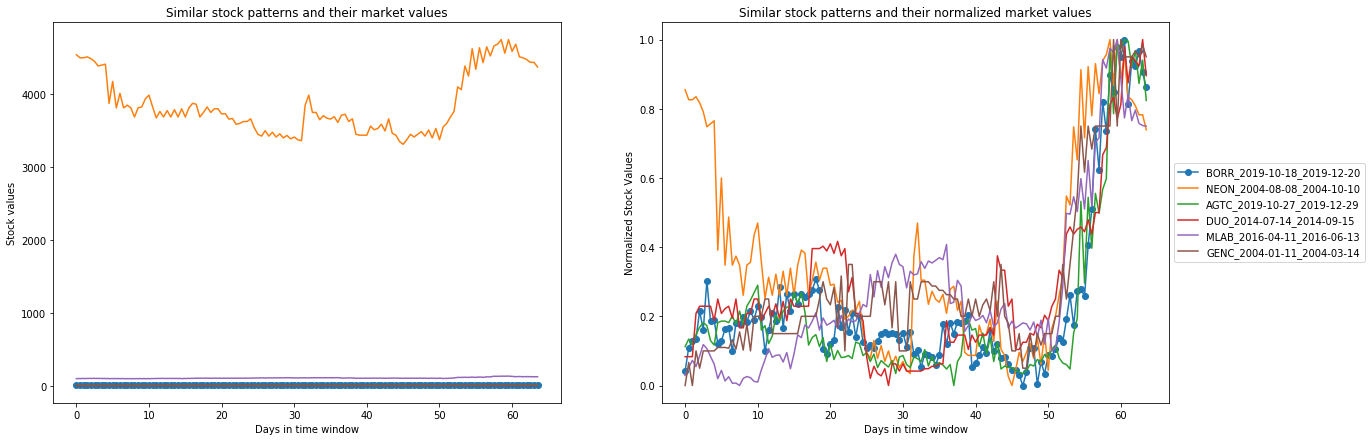


Queried: HCCO_2020-01-28_2020-03-31

 The most similar items from the vector index:


,id,score,values
0,HCCO_2020-01-28_2020-03-31,1.000000,"[9.95, 10.0, 10.05, 10.05, 10.05, 10.05, 10.05..."
1,TEI_2002-04-29_2002-07-01,0.999724,"[12.0, 12.08, 12.1, 12.1, 12.13, 12.2, 12.2, 1..."
2,BY_2018-06-25_2018-08-27,0.999667,"[23.76, 23.13, 23.13, 23.11, 23.2, 22.71, 22.7..."
3,OSK_2016-12-18_2017-02-19,0.999616,"[66.9233322, 66.8233337, 66.27, 66.97, 66.98, ..."
4,PKBK_2019-10-27_2019-12-29,0.999610,"[22.0121212, 21.9757576, 22.09091, 22.0181828,..."
5,RGR_2012-02-08_2012-04-11,0.999577,"[43.05, 42.26, 42.22, 42.41, 42.03, 41.8, 42.0..."


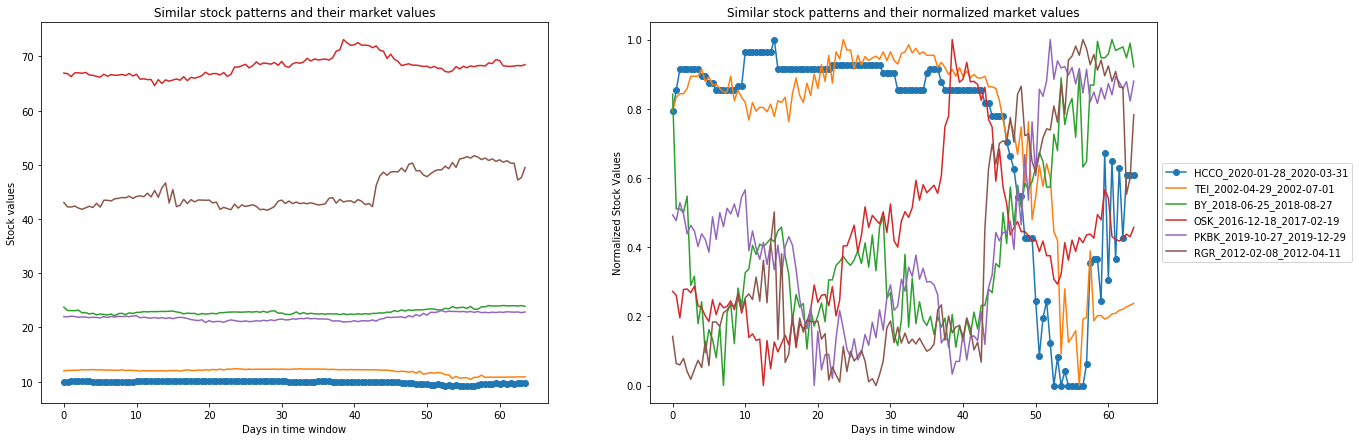


Queried: PUMP_2019-11-22_2020-01-24

 The most similar items from the vector index:


,id,score,values
0,PUMP_2019-11-22_2020-01-24,1.000000,"[8.34, 8.27, 8.31333351, 8.42, 8.28666687, 8.5..."
1,RGR_2014-07-07_2014-09-08,0.999919,"[59.78, 58.95, 58.7, 58.64, 58.65, 58.46, 57.7..."
2,TVIX_2015-09-15_2015-11-17,0.999819,"[322500.0, 266500.0, 246250.0, 234500.0, 23175..."
3,STNE_2018-12-14_2019-02-15,0.999745,"[18.4, 17.71, 18.14, 17.6833324, 17.8800011, 1..."
4,SCVL_2004-03-18_2004-05-20,0.999720,"[10.373333, 10.2333336, 10.2266665, 10.2066669..."
5,AWI_2015-12-20_2016-02-21,0.999673,"[45.876667, 45.3466644, 45.77, 45.17, 45.19, 4..."


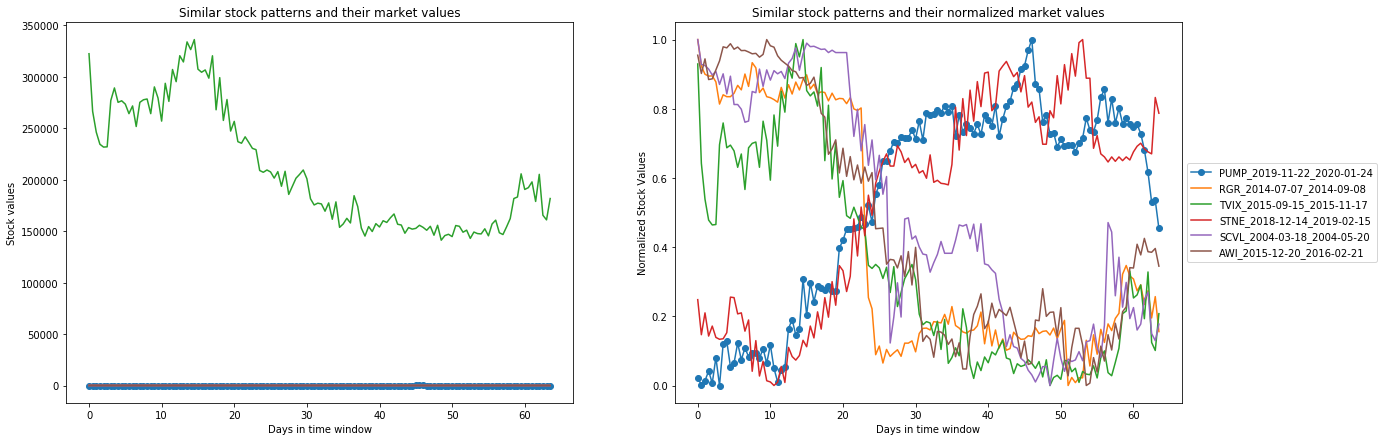

In [31]:
# Iterate and show query results for each query item
for query_item, q_res in zip(query_ids, query_results):
    print(f'\nQueried: {query_item}')
    res_df = pd.DataFrame(
        {
            'id': [res.id for res in q_res.matches], 
            'score': [res.score for res in q_res.matches]
        }
    )

    # Use simple index to retrieve historical prices for query result items
    res_df['values'] = res_df.id.apply(lambda x: [res.values for res in simple_index.fetch(ids=[x]).vectors.values()][0])
    res_df = filter_results(query_item, res_df, historical_only=False)
    show_query_results(query_item, res_df.head(6))

## Conclusion
Pattern matching of time series data is an important task affecting time series clustering, labeling, classification, and recommendation. 

We used the similarity search to find the most similar patterns in stocks data. We tried two different approaches to create vector representations of time series. First, we used the raw data of historical prices, and then we represented time-series as a set of statistical features. In both cases, we retrieved the top 100 best matches from the Pinecone similarity search service. Then we further filtered and showed only the top 5 most similar stock trends. (We did that to make sure we retrieve a diverse set of stocks. Otherwise, we might get consecutive time windows for the same stock.)

The simple approach turned out to give good results. When using Kats' time series features, we got somehow mixed results. We noticed that the most similar feature embeddings sometimes retrieve reverse patterns. 

Yet, we note that the literature has plentiful advanced time series representation techniques. Starting from sequential deep neural network approaches such as LSTMs and RNNs, combining frequency-domain representations with convolutional neural networks, and even applying deep neural graphs embeddings. We encourage you to explore this fascinating domain. Feel free to try it along with the Pinecone service, and [share](https://www.pinecone.io/contact/) your findings with us!

## Delete indexes

Delete the indexes once you are sure that you do not want to use it anymore. Once the index is deleted, you cannot use it again.



In [32]:
pinecone.delete_index(simple_index_name)
pinecone.delete_index(kats_index_name)